In [ ]:
import networkx as nx
import pandas as pd
dataset = "2009"

In [2]:
edges = pd.read_csv(f"../../preds{dataset}/network.tsv", sep="\t")

In [3]:
G = nx.from_pandas_edgelist(edges, source="source", target="target", edge_attr="rel", create_using=nx.DiGraph())

# Add node properties
source_ner_dict = edges.set_index('source')['source_ner'].to_dict()
target_ner_dict = edges.set_index('target')['target_ner'].to_dict()

for node in G.nodes():
    G.nodes[node]['ner'] = source_ner_dict.get(node, target_ner_dict.get(node, None))

In [4]:
# Calculate degree for all nodes that have the 'INHABITS' rel type edge
inhabits_edges = [(u, v) for u, v, d in G.edges(data=True) if d['rel'] == 'INHABITS']
inhabits_nodes = set([u for u, v in inhabits_edges] + [v for u, v in inhabits_edges])

# Create a subgraph with only 'INHABITS' edges
inhabits_G = G.edge_subgraph(inhabits_edges).copy()

# Calculate degree for each node in the subgraph
inhabits_degrees = dict(inhabits_G.degree(inhabits_nodes))

# Sort nodes by degree in descending order
sorted_inhabits_degrees = sorted(inhabits_degrees.items(), key=lambda item: item[1], reverse=True)

# Print the top degree nodes
top_n = 200  # Number of top nodes to display
print(f"Top {top_n} nodes with highest degrees for 'INHABITS' rel type edge:")
for node, degree in sorted_inhabits_degrees[:top_n]:
    print(f"Node: {node}, Degree: {degree}")

Top 200 nodes with highest degrees for 'INHABITS' rel type edge:
Node: soil, Degree: 1973
Node: human, Degree: 1107
Node: t__468063, Degree: 853
Node: marine, Degree: 713
Node: mouse, Degree: 407
Node: environmental, Degree: 335
Node: rhizosphere, Degree: 332
Node: t__447400, Degree: 313
Node: chicken, Degree: 300
Node: rice, Degree: 298
Node: pig, Degree: 296
Node: patient, Degree: 292
Node: food, Degree: 281
Node: wheat, Degree: 279
Node: feces, Degree: 277
Node: gut, Degree: 262
Node: blood, Degree: 255
Node: tomato, Degree: 253
Node: t__12278, Degree: 241
Node: seawater, Degree: 241
Node: milk, Degree: 224
Node: human feces, Degree: 224
Node: water, Degree: 223
Node: t__132830, Degree: 222
Node: marine sediment, Degree: 214
Node: cheese, Degree: 206
Node: freshwater, Degree: 204
Node: hot spring, Degree: 201
Node: sediment, Degree: 199
Node: root, Degree: 199
Node: plant, Degree: 192
Node: maize, Degree: 192
Node: kimchi, Degree: 191
Node: wastewater, Degree: 169
Node: roots, Degre

In [5]:
# Find all nodes with ner=STRAIN that are connected to "human" with INHABITS edge
environment = "human"
strain_nodes_connected_to_human = [
    node for node in G.nodes()
    if G.nodes[node].get('ner') == 'STRAIN' and
    G.has_edge(node, environment) and
    G[node][environment]['rel'] == 'INHABITS'
]

print(f"Number of STRAIN nodes connected to '{environment}' with INHABITS edge: {len(strain_nodes_connected_to_human)}")
print("First few nodes in the list:")
print(strain_nodes_connected_to_human[:5])  # Print first 5 nodes as an example


Number of STRAIN nodes connected to 'human' with INHABITS edge: 1107
First few nodes in the list:
['t__100077', 't__132830', 't__223467', 't__12278', 't__8835']


In [6]:
# Filter the network for nodes that have the label STRAIN (connected to human) and COMPOUND in ner node property
# Also filter edges that are "GROWS_ON" and "SYMBIONT_OF"
filtered_nodes = [
    node for node, data in G.nodes(data=True) 
    if (data.get('ner') == 'STRAIN' and node in strain_nodes_connected_to_human) or data.get('ner') == 'COMPOUND'
]
filtered_G = G.subgraph(filtered_nodes).copy()

# Remove edges with "GROWS_ON" and "SYMBIONT_OF" relationships
edges_to_remove = [(u, v) for u, v, data in filtered_G.edges(data=True) 
                   if data['rel'] in ['GROWS_ON', 'SYMBIONT_OF', "INHABITS", "PROMOTES", "INFECTS", "PRESENTS","ASSOCIATED_WITH"]]
filtered_G.remove_edges_from(edges_to_remove)

In [7]:
# Get all types of edges in the filtered network
edge_types = set()
for _, _, data in filtered_G.edges(data=True):
    edge_types.add(data['rel'])

print("Types of edges in the filtered network:")
for edge_type in sorted(edge_types):
    print(f"- {edge_type}")

# Count the occurrences of each edge type
edge_type_counts = {}
for _, _, data in filtered_G.edges(data=True):
    edge_type = data['rel']
    edge_type_counts[edge_type] = edge_type_counts.get(edge_type, 0) + 1

print("\nEdge type counts:")
for edge_type, count in sorted(edge_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{edge_type}: {count}")


Types of edges in the filtered network:
- DEGRADES
- INHIBITS
- PRODUCES
- RESISTS

Edge type counts:
PRODUCES: 4350
INHIBITS: 3126
RESISTS: 1801
DEGRADES: 563


In [8]:
# Drop nodes that don't have an edge
filtered_G.remove_nodes_from(list(nx.isolates(filtered_G)))

# Calculate the number of edges and nodes for filtered_G after dropping isolated nodes
num_edges = filtered_G.number_of_edges()
num_nodes = filtered_G.number_of_nodes()

print(f"Number of edges in filtered_G: {num_edges}")
print(f"Number of nodes in filtered_G: {num_nodes}")


Number of edges in filtered_G: 9840
Number of nodes in filtered_G: 5396


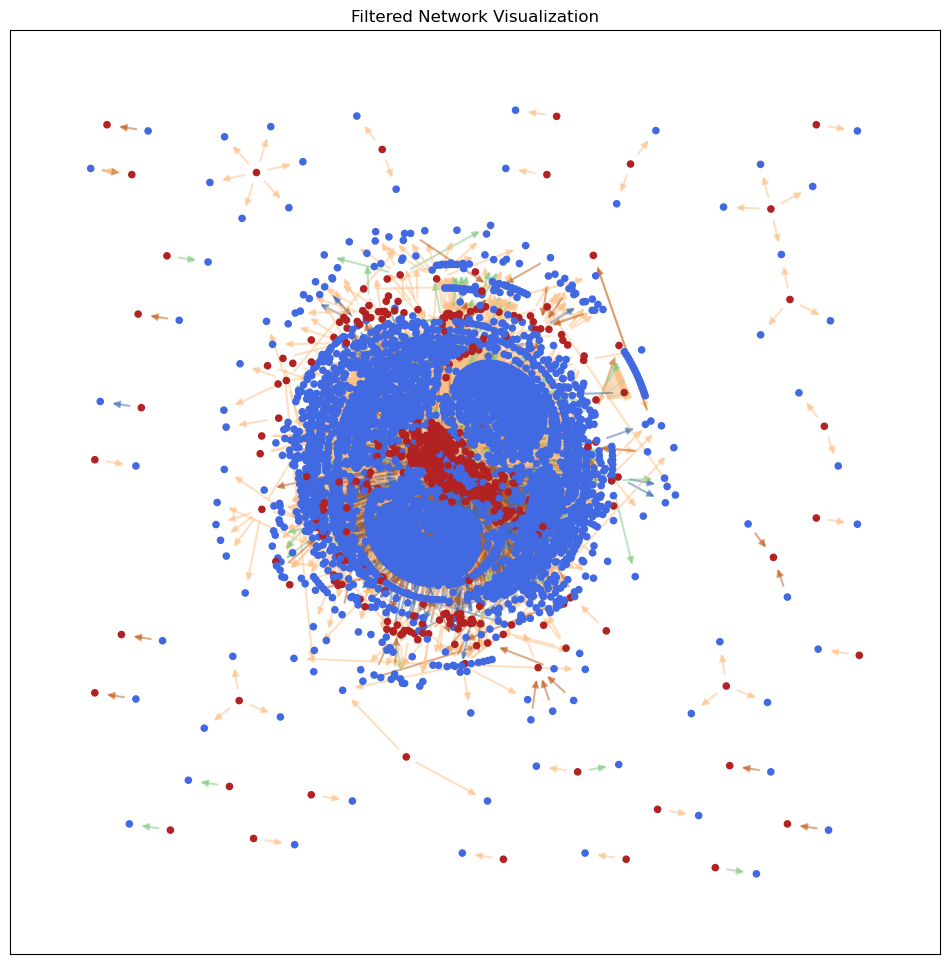

In [9]:
import matplotlib.pyplot as plt

# Define colors for node types
node_color_map = {
    'STRAIN': 'firebrick',
    'COMPOUND': 'royalblue',
}

# Define colors for edge types dynamically based on the edge types present in the network
# Using a different colormap for nicer colors and making edges darker
unique_edge_types = set(data['rel'] for _, _, data in filtered_G.edges(data=True))
edge_color_map = {edge_type: plt.cm.Accent(i / len(unique_edge_types), alpha=0.5) for i, edge_type in enumerate(unique_edge_types)}  # Adjusted alpha for even darker edges

# Get node colors based on 'ner' property
node_colors = [node_color_map.get(data['ner'], 'gray') for node, data in filtered_G.nodes(data=True)]

# Get edge colors based on 'rel' property
edge_colors = [edge_color_map.get(data['rel'], 'gray') for u, v, data in filtered_G.edges(data=True)]

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.nx_agraph.graphviz_layout(filtered_G)  # positions for all nodes

nx.draw_networkx_nodes(filtered_G, pos, node_color=node_colors, node_size=20)  # Reduced node size from 50 to 20
nx.draw_networkx_edges(filtered_G, pos, edge_color=edge_colors, arrows=True, width=1.5)  # Increased edge width for better visibility
# Remove node labels to not show the names of the nodes
nx.draw_networkx_labels(filtered_G, pos, font_size=8, labels={})

plt.title("Filtered Network Visualization")
plt.savefig(f"figures/network/filtered_network_{environment}.pdf", bbox_inches='tight')


In [10]:
import networkx as nx
from itertools import combinations

def count_specific_triad_patterns(G):
    triad_patterns_count = {}
    strain_nodes = [node for node in G.nodes() if node.startswith('t__')]
    compound_nodes = [node for node in G.nodes() if not node.startswith('t__')]
    
    for strain1, strain2 in combinations(strain_nodes, 2):
        for compound in compound_nodes:
            if G.has_edge(strain1, compound) and G.has_edge(strain2, compound):
                edge1 = G[strain1][compound]
                edge2 = G[strain2][compound]
                pattern = tuple(sorted([(strain1, compound, edge1['rel']), (strain2, compound, edge2['rel'])]))
                
                if pattern in triad_patterns_count:
                    triad_patterns_count[pattern] += 1
                else:
                    triad_patterns_count[pattern] = 1

    return triad_patterns_count

# Count the types of triad patterns in filtered_G
triad_counts = count_specific_triad_patterns(filtered_G)
print("Triad pattern counts (only triads with different strains):")
for pattern, count in triad_counts.items():
    print(f"{pattern}: {count}")

Triad pattern counts (only triads with different strains):
(('t__122157', 'sialic acid', 'PRODUCES'), ('t__24565', 'sialic acid', 'PRODUCES')): 1
(('t__24565', 'h_2s', 'PRODUCES'), ('t__44787', 'h_2s', 'PRODUCES')): 1
(('t__24565', 'h_2s', 'PRODUCES'), ('t__8835', 'h_2s', 'PRODUCES')): 1
(('t__24565', 'sialic acid', 'PRODUCES'), ('t__30356', 'sialic acid', 'PRODUCES')): 1
(('t__24565', 'sialic acid', 'PRODUCES'), ('t__89135', 'sialic acid', 'PRODUCES')): 1
(('t__12278', 'h_2s', 'PRODUCES'), ('t__24565', 'h_2s', 'PRODUCES')): 1
(('t__24565', 'h_2s', 'PRODUCES'), ('t__35290', 'h_2s', 'PRODUCES')): 1
(('t__24565', 'h_2s', 'PRODUCES'), ('t__73074', 'h_2s', 'PRODUCES')): 1
(('t__24565', 'h_2s', 'PRODUCES'), ('t__3520', 'h_2s', 'PRODUCES')): 1
(('t__24565', 'h_2s', 'PRODUCES'), ('t__480700', 'h_2s', 'PRODUCES')): 1
(('t__165965', 'sialic acid', 'PRODUCES'), ('t__24565', 'sialic acid', 'PRODUCES')): 1
(('t__24565', 'h_2s', 'PRODUCES'), ('t__79496', 'h_2s', 'PRODUCES')): 1
(('t__16263', 'h_2s'

In [11]:
# Count all types of connections, independently of the node labels
connection_counts = {}

for pattern, count in triad_counts.items():
    # Extract only the relationship types from each edge in the pattern
    connections = tuple(sorted(edge[2] for edge in pattern))
    
    if connections in connection_counts:
        connection_counts[connections] += count
    else:
        connection_counts[connections] = count

print("Connection type counts:")
for connections, count in connection_counts.items():
    print(f"{connections}: {count}")

connection_counts

Connection type counts:
('PRODUCES', 'PRODUCES'): 11252
('DEGRADES', 'PRODUCES'): 843
('RESISTS', 'RESISTS'): 13890
('DEGRADES', 'RESISTS'): 365
('INHIBITS', 'INHIBITS'): 385
('DEGRADES', 'DEGRADES'): 281
('PRODUCES', 'RESISTS'): 515
('INHIBITS', 'RESISTS'): 76
('INHIBITS', 'PRODUCES'): 110
('DEGRADES', 'INHIBITS'): 4


{('PRODUCES', 'PRODUCES'): 11252,
 ('DEGRADES', 'PRODUCES'): 843,
 ('RESISTS', 'RESISTS'): 13890,
 ('DEGRADES', 'RESISTS'): 365,
 ('INHIBITS', 'INHIBITS'): 385,
 ('DEGRADES', 'DEGRADES'): 281,
 ('PRODUCES', 'RESISTS'): 515,
 ('INHIBITS', 'RESISTS'): 76,
 ('INHIBITS', 'PRODUCES'): 110,
 ('DEGRADES', 'INHIBITS'): 4}

In [12]:
# Classify strain-strain connections based on triad counts
strain_connections = {}

for pattern, count in triad_counts.items():
    strain1, compound, rel1 = pattern[0]
    strain2, _, rel2 = pattern[1]
    
    if strain1.startswith('t__') and strain2.startswith('t__'):
        connection_type = None
        
        # if rel1 == rel2 == 'PRODUCES':
        #     connection_type = 'negative'
        if rel1 == rel2 == 'DEGRADES':
            connection_type = 'negative'
        elif (rel1 == 'PRODUCES' and rel2 == 'DEGRADES') or (rel1 == 'DEGRADES' and rel2 == 'PRODUCES'):
            connection_type = 'positive'
        elif (rel1 == 'PRODUCES' and rel2 == 'INHIBITS') or (rel1 == 'INHIBITS' and rel2 == 'PRODUCES'):
            connection_type = 'negative'
        elif (rel1 == 'PRODUCES' and rel2 == 'RESISTS') or (rel1 == 'RESISTS' and rel2 == 'PRODUCES'):
            connection_type = 'positive'
        
        if connection_type:
            key = tuple(sorted([strain1, strain2]))
            if key not in strain_connections:
                strain_connections[key] = {'positive': 0, 'negative': 0}
            strain_connections[key][connection_type] += count

print("Strain-strain connections:")
for strains, connections in strain_connections.items():
    print(f"{strains}: Positive: {connections['positive']}, Negative: {connections['negative']}")

print(f"Total number of strain-strain connections: {len(strain_connections)}")
print(f"Total number of triad patterns: {len(triad_counts)}")

Strain-strain connections:
('t__24565', 't__50907'): Positive: 1, Negative: 0
('t__85518', 't__88170'): Positive: 0, Negative: 1
('t__44787', 't__85518'): Positive: 1, Negative: 0
('t__85518', 't__89135'): Positive: 1, Negative: 0
('t__85518', 't__94811'): Positive: 0, Negative: 1
('t__12278', 't__85518'): Positive: 2, Negative: 0
('t__338666', 't__85518'): Positive: 1, Negative: 0
('t__85518', 't__91890'): Positive: 0, Negative: 1
('t__66103', 't__85518'): Positive: 1, Negative: 1
('t__165965', 't__85518'): Positive: 1, Negative: 0
('t__79496', 't__85518'): Positive: 0, Negative: 1
('t__693823', 't__85518'): Positive: 1, Negative: 0
('t__73809', 't__85518'): Positive: 1, Negative: 0
('t__154818', 't__85518'): Positive: 0, Negative: 1
('t__185646', 't__7604'): Positive: 1, Negative: 0
('t__185646', 't__70519'): Positive: 1, Negative: 0
('t__185646', 't__77534'): Positive: 0, Negative: 1
('t__185646', 't__94811'): Positive: 1, Negative: 0
('t__185646', 't__66103'): Positive: 2, Negative

In [13]:
vertices = pd.read_csv(f"../../preds{dataset}/strainselect/StrainSelect21_vertices.tab.txt", sep="\t")

/scratch/slurm_tmpdir/job_24614555/ipykernel_586586/1239448866.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vertices = pd.read_csv(f"../../preds{dataset}/strainselect/StrainSelect21_vertices.tab.txt", sep="\t")


In [14]:
names = vertices[(vertices["StrainSelectID"]=="t__30867")&(vertices["vertex_type"]=="gss")].vertex.values

In [15]:
def get_strain_id(strain):
    names = vertices[(vertices["StrainSelectID"]==strain)&(vertices["vertex_type"]=="gss")].vertex.values
    return min(names, key=len)

In [16]:
print("Strain-strain connections with strain IDs (sorted by total count, descending):")
sorted_connections = sorted(strain_connections.items(), key=lambda x: sum(x[1].values()), reverse=True)
for strains, connections in sorted_connections:
    strain1_id = get_strain_id(strains[0])
    strain2_id = get_strain_id(strains[1])
    total_count = connections['positive'] + connections['negative']
    print(f"{(strain1_id, strain2_id)}: Positive: {connections['positive']}, Negative: {connections['negative']}, Total: {total_count}")


Strain-strain connections with strain IDs (sorted by total count, descending):
('lactobacillus.lmg.17291', 'escherichia.coli.bl21de3'): Positive: 7, Negative: 6, Total: 13
('escherichia.coli.bl21de3', 'corynebacterium.glutamicum.ha'): Positive: 11, Negative: 0, Total: 11
('escherichia.coli.bl21de3', 'escherichia.coli.eli.51'): Positive: 5, Negative: 3, Total: 8
('lactobacillus.plantarum.1', 'escherichia.coli.bl21de3'): Positive: 6, Negative: 2, Total: 8
('lactobacillus.lmg.17291', 'escherichia.coli.nissle.1917'): Positive: 7, Negative: 0, Total: 7
('lactobacillus.lmg.17291', 'escherichia.coli.eli.51'): Positive: 6, Negative: 0, Total: 6
('lactobacillus.lmg.17291', 'corynebacterium.glutamicum.ha'): Positive: 5, Negative: 1, Total: 6
('escherichia.coli.bl21de3', 'bifidobacterium.breve.ucc2003'): Positive: 3, Negative: 3, Total: 6
('escherichia.coli.bl21de3', 'lactobacillus.plantarum.wcfs1'): Positive: 5, Negative: 1, Total: 6
('escherichia.coli.eli.51', 'corynebacterium.glutamicum.ha'): 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Create an undirected graph
G = nx.Graph()

# Add edges to the graph
for strains, connections in sorted_connections:
    strain1_id = get_strain_id(strains[0])
    strain2_id = get_strain_id(strains[1])
    
    if connections['positive'] > 0:
        G.add_edge(strain1_id, strain2_id, weight=connections['positive'], connection_type='positive')
    
    if connections['negative'] > 0:
        G.add_edge(strain1_id, strain2_id, weight=connections['negative'], connection_type='negative')

# Set up the plot
plt.figure(figsize=(10, 10))

# Define layout
pos = nx.nx_agraph.graphviz_layout(G)

# Draw nodes with a black outline
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', edgecolors='black', linewidths=1)

# Draw edges
positive_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['connection_type'] == 'positive']
negative_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['connection_type'] == 'negative']

all_weights = [G[u][v]['weight'] for (u, v) in G.edges()]
max_weight = max(all_weights)

nx.draw_networkx_edges(G, pos, edgelist=positive_edges, edge_color='#E61A1A', 
                       width=[G[u][v]['weight']/max_weight*5 for (u, v) in positive_edges])
nx.draw_networkx_edges(G, pos, edgelist=negative_edges, edge_color='#0D79F2', 
                       width=[G[u][v]['weight']/max_weight*5 for (u, v) in negative_edges])

# Add labels with improved visibility
texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(x, y, node, fontsize=7, ha='center', va='center', 
                          bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                          zorder=10))  # Ensure text is on top

# Adjust label positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))

plt.title(f"Strain-strain connections for {environment}-inhabiters", fontsize=16, fontweight='bold')
plt.axis('off')

# Add a legend with increased visibility
plt.plot([0], [0], color='#E61A1A', label='Positive Connection', linewidth=3)
plt.plot([0], [0], color='#0D79F2', label='Negative Connection', linewidth=3)
plt.legend(fontsize=12, loc='best', bbox_to_anchor=(1, 0.5))

plt.savefig(f"figures/network/strain_strain_connections_{environment}.pdf", bbox_inches='tight')
plt.tight_layout()


In [ ]:
# Calculate positive and negative degree for each node
positive_degree = {}
negative_degree = {}

for node in G.nodes():
    positive_degree[node] = sum(1 for _, _, data in G.edges(node, data=True) if data['connection_type'] == 'positive')
    negative_degree[node] = sum(1 for _, _, data in G.edges(node, data=True) if data['connection_type'] == 'negative')

# Create a DataFrame for analysis and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

degree_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Positive_Degree': [positive_degree[node] for node in G.nodes()],
    'Negative_Degree': [negative_degree[node] for node in G.nodes()]
})

# Set up the plot
plt.figure(figsize=(5, 3))

# Create a scatter plot with color based on position relative to the diagonal
degree_df['Color'] = ['#0D79F2' if row['Negative_Degree'] > row['Positive_Degree'] else '#E61A1A' for _, row in degree_df.iterrows()]
sns.scatterplot(data=degree_df, x='Positive_Degree', y='Negative_Degree', hue='Color', palette=['#0D79F2', '#E61A1A'], legend=False, alpha=0.6)

# Add labels and title
plt.xlabel('Positive degree', fontsize=12)
plt.ylabel('Negative degree', fontsize=12)
plt.title(f'Node degrees in strain-strain connections for {environment}-inhabiters', fontsize=14)

# Add a diagonal line
max_degree = max(degree_df['Positive_Degree'].max(), degree_df['Negative_Degree'].max())
plt.plot([0, max_degree], [0, max_degree], 'k--', alpha=0.5)

# Annotate top 5 nodes by total degree and negative degree
degree_df['Total_Degree'] = degree_df['Positive_Degree'] + degree_df['Negative_Degree']
top_5_nodes = degree_df.nlargest(5, 'Total_Degree')
top_5_negative = degree_df.nlargest(5, 'Negative_Degree')

annotated_nodes = set()

for df in [top_5_nodes, top_5_negative]:
    for _, row in df.iterrows():
        if row['Node'] not in annotated_nodes:
            plt.annotate(row['Node'], (row['Positive_Degree'], row['Negative_Degree']), 
                         xytext=(5, 5), textcoords='offset points', fontsize=8, color='black')
            annotated_nodes.add(row['Node'])

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='More positive connections', markerfacecolor='#E61A1A', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='More negative connections', markerfacecolor='#0D79F2', markersize=10),
    Line2D([0], [0], linestyle='--', color='k', label='Equal positive and negative degrees')
]
plt.legend(handles=legend_elements, loc='best', fontsize=8)

plt.savefig(f"figures/network/strain_strain_node_degrees_{environment}.pdf", bbox_inches='tight')

# Print summary statistics
print("Positive Degree Statistics:")
print(f"Max: {degree_df['Positive_Degree'].max()}")
print(f"Min: {degree_df['Positive_Degree'].min()}")
print(f"Average: {degree_df['Positive_Degree'].mean():.2f}")

print("\nNegative Degree Statistics:")
print(f"Max: {degree_df['Negative_Degree'].max()}")
print(f"Min: {degree_df['Negative_Degree'].min()}")
print(f"Average: {degree_df['Negative_Degree'].mean():.2f}")

print("\nTop 5 nodes by total degree:")
print(top_5_nodes[['Node', 'Positive_Degree', 'Negative_Degree', 'Total_Degree']])

print("\nTop 5 nodes by negative degree:")
print(top_5_negative[['Node', 'Positive_Degree', 'Negative_Degree', 'Total_Degree']])